In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import defaultdict
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from tqdm.notebook import tqdm
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings("ignore")

# Feature Engineering

By the analysis at the end of the `tree_models_with_lags` notebook, we found that the Patient's Most Recent History has great importance and that Time and Age also have some impact on the UPDRS score progression.

Therefore, we will primarily focus on creating features that can reflect more details about a patient's historical UPDRS score, while paying some attention to the interaction of time and age with historical UPDRS scores.


In [19]:
data = pd.read_csv("../3. EDA and data preprocessing/preprocessed_training_data.csv")

with open('../3. EDA and data preprocessing/time_dependent_clinical_features.txt', 'r') as file:
    clinical_feature_time_dependent = file.readlines()
clinical_feature_time_dependent = [item.strip() for item in clinical_feature_time_dependent]

with open('../3. EDA and data preprocessing/static_clinical_features.txt', 'r') as file:
    clinical_feature_non_time_dependent = file.readlines()
clinical_feature_non_time_dependent = [item.strip() for item in clinical_feature_non_time_dependent]

In [ ]:
updrs_cols = ['updrs_1', 'updrs_2', 'updrs_3']
cols_to_lag = updrs_cols + clinical_feature_time_dependent

data = data.sort_values(['participant_id', 'visit_month'])

for lag in [1, 2, 3]:
    for col in cols_to_lag:
        data[f'{col}_lag_{lag}'] = data.groupby('participant_id')[col].shift(lag)


lagged_feature_cols = [col for col in data.columns if '_lag_' in col]


# Rate of Change / Slopes
print("Adding change rate features...")
for score in updrs_cols:

    data[f'{score}_slope_1'] = data[f'{score}_lag_1'] - data[f'{score}_lag_2']

    data[f'{score}_slope_2'] = data[f'{score}_lag_2'] - data[f'{score}_lag_3']

    data[f'{score}_slope_mean'] = (data[f'{score}_lag_1'] - data[f'{score}_lag_3']) / 2


# Rolling Averages
print("Adding rolling average features...")
for score in updrs_cols:

    lag_cols = [f'{score}_lag_{i}' for i in [1,2,3]]
    data[f'{score}_mean_lags'] = data[lag_cols].mean(axis=1)

    data[f'{score}_weighted'] = (
        0.6 * data[f'{score}_lag_1'] +
        0.3 * data[f'{score}_lag_2'] +
        0.1 * data[f'{score}_lag_3']
    )

    data[f'{score}_evenly_weighted'] = (
        data[f'{score}_lag_1'] +
        data[f'{score}_lag_2'] +
        data[f'{score}_lag_3']
    )/3

# Volatility Features
print("Adding volatility features...")
for score in updrs_cols:

    data[f'{score}_lag_std'] = data[lag_cols].std(axis=1)

    data[f'{score}_lag_range'] = data[lag_cols].max(axis=1) - data[lag_cols].min(axis=1)

# Longitudinal Summaries
print("Adding longitudinal summary features...")
for score in updrs_cols:

    data[f'{score}_trend'] = data.groupby('participant_id')[f'{score}_lag_1'].transform(
        lambda x: x.diff().mean()
    )

# Time-Adjusted Features
print("Adding time-adjusted features...")
for score in updrs_cols:

    data[f'{score}_time_adj'] = data[f'{score}_lag_1'] / (data['visit_month'] + 2)

# Patient age progression
data['age_progression'] = data['age_at_baseline'] + data['visit_month'] / 12


# interaction feature
data['age_x_visit_month'] = data['age_at_baseline'] * (data['visit_month'] )

# UPDRS Ratios
print("Adding UPDRS ratio features...")
data['motor_ratio'] = data['updrs_3_lag_1'] / (
    data['updrs_1_lag_1'] +
    data['updrs_2_lag_1'] +
    1e-5  # Prevents division by zero
)


lagged_feature_cols = [col for col in data.columns if '_lag_' in col]

trend_feature_cols = [col for col in data.columns if any(x in col for x in ['slope', 'mean', 'weighted', 'std', 'range', 'adj', 'ratio', 'trend'])]

final_feature_cols = clinical_feature_non_time_dependent + lagged_feature_cols + trend_feature_cols + ["age_x_visit_month"]

# avoid duplicated elements arising from both lagged_feature_cols and trend_feature_cols
final_feature_cols = list(dict.fromkeys(final_feature_cols))

# defragmentation to improve performance
data=data.copy()


Adding change rate features...
Adding rolling average features...
Adding volatility features...
Adding time-adjusted features...
Adding UPDRS ratio features...
Adding longitudinal summary features...


##### Cross Validation

In [21]:
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store results
mae_results = defaultdict(list)
# Use a progress bar for long-running CV
cv_split_generator = gkf.split(data, groups=data["participant_id"])

print("Starting cross-validation for Random Forest with Lagged Features...")

for fold, (train_idx, test_idx) in enumerate(tqdm(cv_split_generator, total=n_splits, desc="Running CV")):
    train_fold = data.iloc[train_idx]
    holdout_fold = data.iloc[test_idx]

    X_train, y_train = train_fold[final_feature_cols], train_fold[updrs_cols]
    X_holdout, y_holdout = holdout_fold[final_feature_cols], holdout_fold[updrs_cols]

    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train)


    X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=final_feature_cols, index=X_train.index)
    X_holdout_imputed = pd.DataFrame(imputer.transform(X_holdout), columns=final_feature_cols, index=X_holdout.index)


    y_train_clean = y_train.dropna()
    X_train_clean = X_train_imputed.loc[y_train_clean.index]



    lgbm_estimator = lgb.LGBMRegressor(
        objective='regression_l1',
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        n_jobs=-1,
        random_state=42,
        verbose=-1,
    )
    model = MultiOutputRegressor(lgbm_estimator)

    model.fit(X_train_clean, y_train_clean)


    predictions_array = model.predict(X_holdout_imputed)
    predictions_df = pd.DataFrame(predictions_array, index=X_holdout.index, columns=updrs_cols)

    for col in updrs_cols:
        actual_values = y_holdout[col]
        predicted_values = predictions_df[col]

        valid_indices = actual_values.notna()
        mae = mean_absolute_error(actual_values[valid_indices], predicted_values[valid_indices])

        mae_results[col].append(mae)

Starting cross-validation for Random Forest with Lagged Features...


Running CV:   0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
print("\n--- Cross-Validation Results for Random Forest w/ Lags ---")
for col, scores in mae_results.items():
    avg_mae = np.mean(scores)
    std_mae = np.std(scores)
    print(f"Average MAE for {col}: {avg_mae:.4f} (+/- {std_mae:.4f})")


--- Cross-Validation Results for Random Forest w/ Lags ---
Average MAE for updrs_1: 2.5258 (+/- 0.0443)
Average MAE for updrs_2: 2.4355 (+/- 0.0259)
Average MAE for updrs_3: 5.3845 (+/- 0.0159)


### Observation:
The model is improved, though less compared to the improvement from the baseline model to tree models with lags.

### Analysis:
The engineering features are valuable, but they are refining the core knowledge the model already gained from the simple lags. They help the model make a better decision, but the fundamental information was already contained in the lags. Combined with the knowledge of how tree models work, this phenomena are expected.


--- Feature Importance (from last fold's model) ---
Top 20 Features (Averaged Across UPDRS Targets):
                    updrs_1  updrs_2  updrs_3  average_importance
updrs_3_trend           915      708     2164         1262.333333
updrs_2_trend           871     1970      652         1164.333333
updrs_2_mean_lags       477     2575      333         1128.333333
age_at_baseline         715      514     1752          993.666667
age_x_visit_month      1019      694     1264          992.333333
updrs_3_time_adj        803     1491      542          945.333333
updrs_3_mean_lags       586      464     1742          930.666667
updrs_1_trend          1292      886      517          898.333333
updrs_1_lag_3           417     1728      341          828.666667
updrs_3_lag_1           567     1323      555          815.000000
updrs_1_weighted        689      398     1305          797.333333
updrs_1_lag_std         929      705      683          772.333333
updrs_3_slope_2         724     1015    

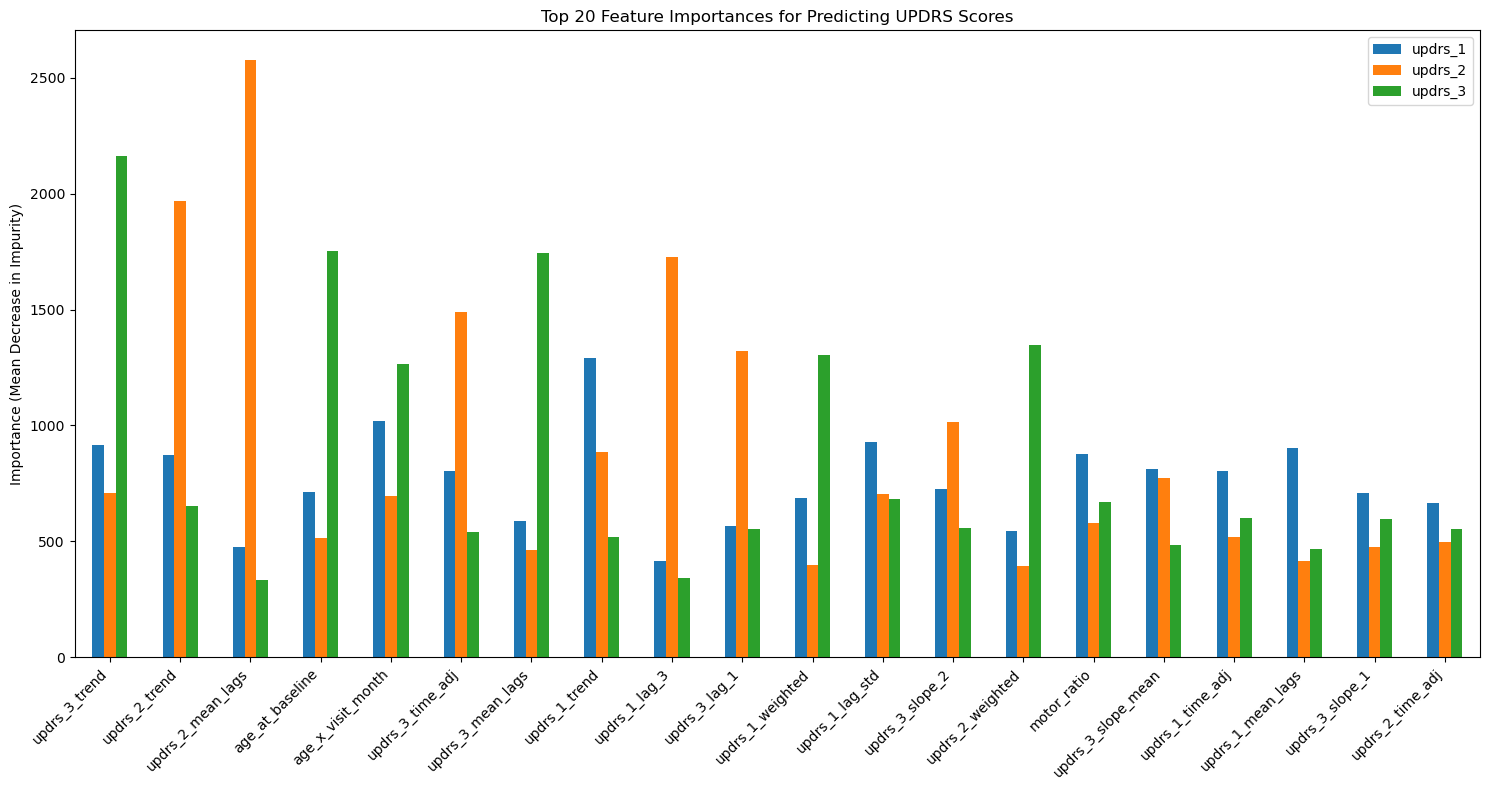

In [23]:
# Extract feature importance from the model trained on the LAST fold
print("\n--- Feature Importance (from last fold's model) ---")
importance_df = pd.DataFrame(index=final_feature_cols)

for i, estimator in enumerate(model.estimators_):
    target_name = updrs_cols[i]
    importances = estimator.feature_importances_
    importance_df[target_name] = importances

importance_df['average_importance'] = importance_df.mean(axis=1)
top_features = importance_df.sort_values(by='average_importance', ascending=False).head(20)
importance_df.to_csv("feature_importance_after_engineering.csv")


print("Top 20 Features (Averaged Across UPDRS Targets):")
print(top_features)

# Visualize the top features
top_features[updrs_cols].plot(kind='bar', figsize=(15, 8))
plt.title('Top 20 Feature Importances for Predicting UPDRS Scores')
plt.ylabel('Importance (Mean Decrease in Impurity)')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Observation:

Compared with the feature importance for LGBM trained on the un-engineered features, we saw more historical-record-related features here, further confirming our intuition that the trend or growth is the key signals in a time series dataset.

# Hyperparameter tuning


In [24]:
importance_df = pd.read_csv("feature_importance_after_engineering.csv")
if 'Unnamed: 0' in importance_df.columns:
    importance_df.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)

N_TOP_FEATURES = 100
final_feature_cols_selected = importance_df.sort_values(
    by='average_importance',
    ascending=False
).head(N_TOP_FEATURES)['feature'].tolist()
print(f"Proceeding with the top {len(final_feature_cols_selected)} features for tuning.")

data_cleaned = data.dropna(subset=updrs_cols).copy()

X = data_cleaned[final_feature_cols_selected]
y = data_cleaned[updrs_cols]
groups = data_cleaned['participant_id']

Proceeding with the top 75 features for tuning.


In [25]:
cv_strategy = GroupKFold(n_splits=5)


lgbm_estimator = lgb.LGBMRegressor(objective='regression_l1', random_state=42, n_jobs=1, verbose=-1)
multi_output_model = MultiOutputRegressor(lgbm_estimator)


pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', multi_output_model)
])


param_dist = {
    'model__estimator__n_estimators': randint(200, 1500),
    'model__estimator__learning_rate': uniform(0.01, 0.08),
    'model__estimator__num_leaves': randint(20, 60),
    'model__estimator__max_depth': randint(5, 15),
    'model__estimator__reg_alpha': uniform(0, 1),
    'model__estimator__reg_lambda': uniform(0, 1),
    'model__estimator__colsample_bytree': uniform(0.6, 0.4),
    'model__estimator__subsample': uniform(0.6, 0.4),
}

### Run Randomized Search with Cross-Validation

In [26]:
print("\nStarting Randomized Search for LightGBM Hyperparameters...")

# We need a scorer that can handle multi-output. We'll use a simple average MAE.
# scikit-learn maximises scores, so we use the negative of our error metric.
neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Instantiate RandomizedSearchCV with the PIPELINE as the estimator
random_search = RandomizedSearchCV(
    estimator=pipeline,  # Use the pipeline here
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter combinations to try. 50 is a robust number.
    cv=cv_strategy, # IMPORTANT: Pass your GroupKFold object here!
    scoring=neg_mae_scorer,
    verbose=2,
    n_jobs=-1, # Use all available cores
    random_state=42
)

# Run the search. Pass the original X with NaNs. The pipeline will handle imputation.
random_search.fit(X, y, groups=groups)


Starting Randomized Search for LightGBM Hyperparameters...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,Pipeline(step...erbose=-1)))])
,param_distributions,"{'model__estimator__colsample_bytree': <scipy.stats....002D130ECB680>, 'model__estimator__learning_rate': <scipy.stats....002D131194500>, 'model__estimator__max_depth': <scipy.stats....002D130ECABD0>, 'model__estimator__n_estimators': <scipy.stats....002D130ECB2C0>, ...}"
,n_iter,50
,scoring,make_scorer(m...hod='predict')
,n_jobs,-1
,refit,True
,cv,GroupKFold(n_...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


### View the Results

In [27]:
print("\n--- Hyperparameter Tuning Complete ---")
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation score (Negative MAE): {-random_search.best_score_:.4f}")

best_lgbm_model_pipeline = random_search.best_estimator_

print("\nBest LightGBM model pipeline is now trained and ready for use.")


--- Hyperparameter Tuning Complete ---
Best parameters found: {'model__estimator__colsample_bytree': np.float64(0.6701321079557354), 'model__estimator__learning_rate': np.float64(0.011372888146540019), 'model__estimator__max_depth': 14, 'model__estimator__n_estimators': 631, 'model__estimator__num_leaves': 40, 'model__estimator__reg_alpha': np.float64(0.4734717707805657), 'model__estimator__reg_lambda': np.float64(0.17320186991001518), 'model__estimator__subsample': np.float64(0.7735406596951893)}
Best cross-validation score (Negative MAE): 3.4425

Best LightGBM model pipeline is now trained and ready for use.


### Re-evaluate the Best Model to Get Per-Target MAE Scores

In [28]:
print("\n--- Re-evaluating best model to get per-target MAE ---")

# The best model pipeline is already trained and stored
best_model_pipeline = random_search.best_estimator_

# Store the individual scores
mae_results_best_model = defaultdict(list)

# Use the same data and CV strategy
# X and y are already defined from the previous step
cv_strategy = GroupKFold(n_splits=5)
cv_split_generator = cv_strategy.split(X, y, groups=groups)

for fold, (train_idx, test_idx) in enumerate(tqdm(cv_split_generator, total=n_splits, desc="Final Evaluation")):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_holdout, y_holdout = X.iloc[test_idx], y.iloc[test_idx]

    # Fit the best pipeline on the training fold
    # The pipeline handles imputation internally
    best_model_pipeline.fit(X_train, y_train)

    # Make predictions on the holdout fold
    predictions_array = best_model_pipeline.predict(X_holdout)
    predictions_df = pd.DataFrame(predictions_array, index=y_holdout.index, columns=updrs_cols)

    # Calculate MAE for each target
    for col in updrs_cols:
        actual_values = y_holdout[col]
        predicted_values = predictions_df[col]
        
        # We don't need to check for NaNs in actual_values here because we dropped them
        # when creating the `data_cleaned` dataframe before the search.
        mae = mean_absolute_error(actual_values, predicted_values)
        mae_results_best_model[col].append(mae)

# --- Reporting Final Individual Scores ---
print("\n--- Final Cross-Validated MAE for Best Tuned Model (Per Target) ---")
for col, scores in mae_results_best_model.items():
    avg_mae = np.mean(scores)
    std_mae = np.std(scores)
    print(f"Average MAE for {col}: {avg_mae:.4f} (+/- {std_mae:.4f})")


--- Re-evaluating best model to get per-target MAE ---


Final Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]


--- Final Cross-Validated MAE for Best Tuned Model (Per Target) ---
Average MAE for updrs_1: 2.5129 (+/- 0.0594)
Average MAE for updrs_2: 2.4237 (+/- 0.0884)
Average MAE for updrs_3: 5.3909 (+/- 0.1745)


## Observation

The improvement in terms of mean absolute error is minor. 


## Analysis

LightGBM is a very robust algorithm that performs very well with the chosen hyperparameter. There wasn't much "hidden" performance left for the tuning to find.

## 6. Output the model with the best hyperparameter

In [29]:
import joblib

joblib.dump(best_lgbm_model_pipeline, 'lgbm_model.pkl')

['lgbm_model.pkl']